In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Load dataset
df = pd.read_csv("../../data/data.csv")

# Define features and target
features = [col for col in df.columns if col not in ["ID", "e_Sint", "Sint"]]
X = df[features].values
y = df["Sint"].values.reshape(-1, 1)

# Scale features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Reshape for LSTM: (samples, time_steps=1, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Convert y_scaled to 1D for sklearn compatibility
y_scaled_flat = y_scaled.flatten()

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores, mae_scores, mse_scores, rmse_scores = [], [], [], []

2025-08-16 08:24:11.344538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 08:24:11.352912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755332651.361319    2800 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755332651.363548    2800 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755332651.376346    2800 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # Define LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict and inverse scale
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test)

    # Metrics
    r2 = r2_score(y_test_actual, y_pred)
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)

    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

    print(f"Fold {fold} → R²: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")


I0000 00:00:1755332663.736556    2800 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13220 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1755332672.203808   11545 cuda_dnn.cc:529] Loaded cuDNN version 90300


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 1 → R²: 0.7209, MAE: 0.6609, MSE: 30.1679, RMSE: 5.4925
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 2 → R²: 0.6254, MAE: 0.6560, MSE: 2.4238, RMSE: 1.5569
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 → R²: 0.5964, MAE: 0.6397, MSE: 86.8737, RMSE: 9.3206
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4 → R²: 0.8085, MAE: 0.7543, MSE: 14.9859, RMSE: 3.8712
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 → R²: 0.8614, MAE: 0.4553, MSE: 15.0890, RMSE: 3.8845


In [10]:
# Average metrics
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)

# Accuracy estimation (std-based)
range_y = np.max(y) - np.min(y)
accuracy_r2 = np.std(r2_scores) * 100
accuracy_mae = (1 - np.std(mae_scores) / range_y) * 100
accuracy_mse = (1 - np.std(mse_scores) / range_y) * 100
accuracy_rmse = (1 - np.std(rmse_scores) / range_y) * 100

print("\n🔍 Cross-Validated Performance (LSTM for Sint)")
print(f"Average R²  : {avg_r2:.4f}")
print(f"Average MAE : {avg_mae:.4f}, Accuracy: {accuracy_mae:.2f}%")
print(f"Average MSE : {avg_mse:.4f}, Accuracy: {accuracy_mse:.2f}%")
print(f"Average RMSE: {avg_rmse:.4f}, Accuracy: {accuracy_rmse:.2f}")


🔍 Cross-Validated Performance (LSTM for Sint)
Average R²  : 0.7225
Average MAE : 0.6332, Accuracy: 99.98%
Average MSE : 29.9081, Accuracy: 93.65%
Average RMSE: 4.8251, Accuracy: 99.45


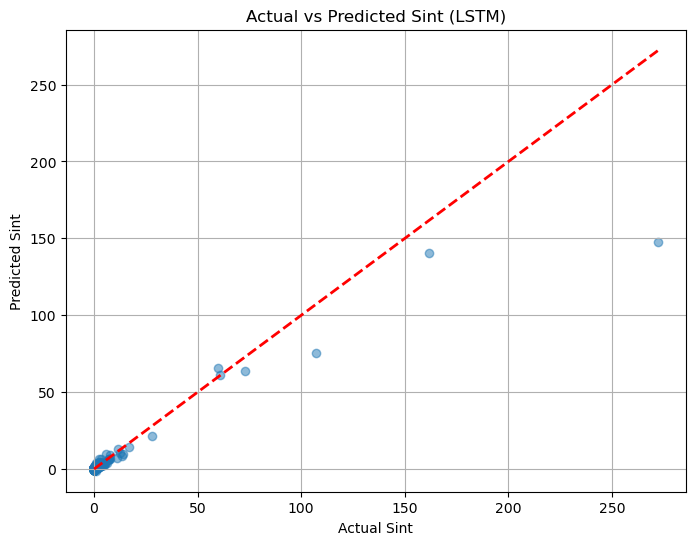

In [8]:
# Final Fold Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)],
         [min(y_test_actual), max(y_test_actual)], 'r--', lw=2)
plt.xlabel('Actual Sint')
plt.ylabel('Predicted Sint')
plt.title('Actual vs Predicted Sint (LSTM)')
plt.grid(True)
plt.show()